/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 6355 images belonging to 15 classes.
Found 270 images belonging to 15 classes.
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/50
199/199 [==============================] - 121s 351ms/step - loss: 3.0789 - accuracy: 0.5090 - val_loss: 14.3185 - val_accuracy: 0.0667
Epoch 2/50
199/199 [==============================] - 41s 203ms/step - loss: 0.2993 - accuracy: 0.9177 - val_loss: 8.7507 - val_accuracy: 0.0667
Epoch 3/50
199/199 [==============================] - 40s 200ms/step - loss: 0.5033 - accuracy: 0.8850 - val_loss: 25.7973 - val_accuracy: 0.0667
Epoch 4/50
199/199 [==============================] - 40s 201ms/step - loss: 0.1391 - accuracy: 0.9607 - val_loss: 9.6918 - val_accuracy: 0.0889
Epoch 5/50
199/199 [==============================] - 41s 205ms/step - loss: 0.0862 - accuracy: 0.9745 - val_loss: 7.3812 - val_accuracy: 0.2963
Epoch 6/50
199/199 [==============================] - 40s 198ms/step - loss: 0.0480 - accuracy: 0.9871 - val_loss: 1.4134 

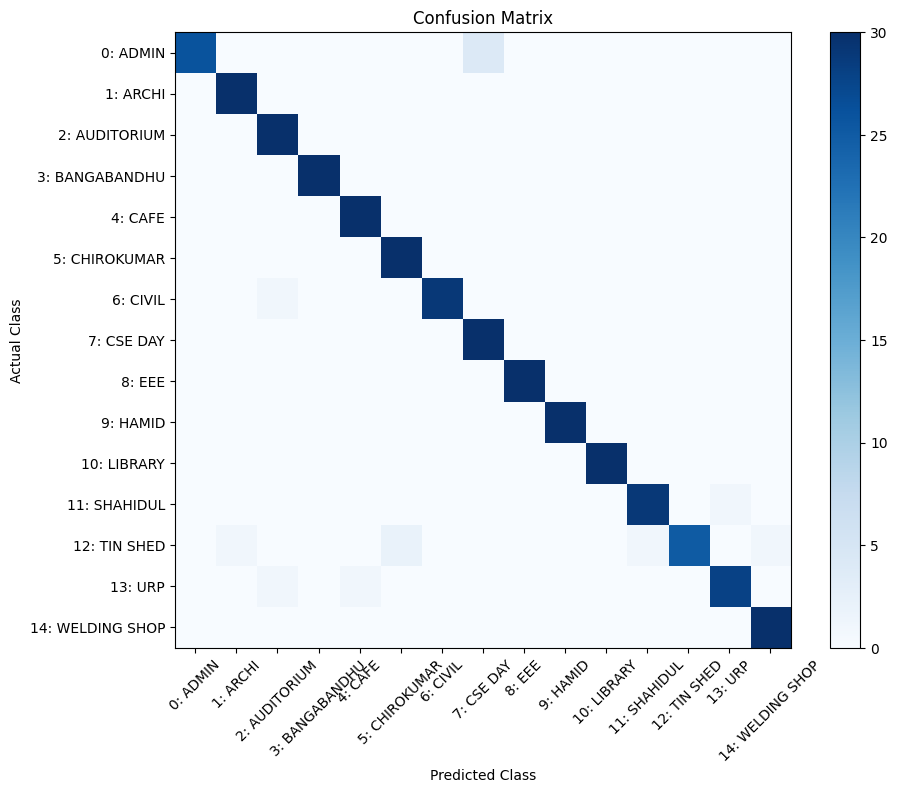

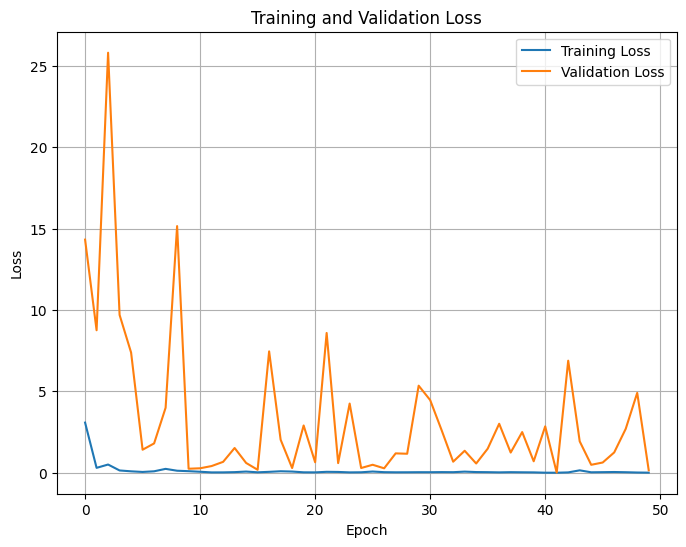

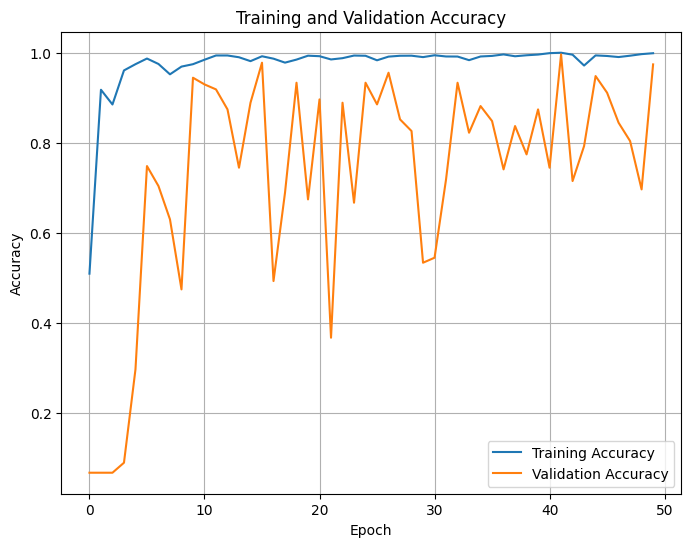

Class Precisions: [1.0, 0.967741935483871, 0.9375, 1.0, 0.967741935483871, 0.9375, 1.0, 0.8823529411764706, 1.0, 1.0, 1.0, 0.9666666666666667, 1.0, 0.9655172413793104, 0.967741935483871]
Class Recalls: [0.8666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9666666666666667, 1.0, 1.0, 1.0, 1.0, 0.9666666666666667, 0.8333333333333334, 0.9333333333333333, 1.0]
Class F1 Scores: [0.9285714285714286, 0.9836065573770492, 0.967741935483871, 1.0, 0.9836065573770492, 0.967741935483871, 0.983050847457627, 0.9375, 1.0, 1.0, 1.0, 0.9666666666666667, 0.9090909090909091, 0.9491525423728815, 0.9836065573770492]
Micro-Precision: 0.9711111111111111
Micro-Recall: 0.9711111111111111
Micro-F1: 0.9711111111111111
Top-1 Accuracy: 0.9711111111111111
Top-5 Accuracy: 1.0


In [1]:
#"Model Training"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/kaggle/input/dataset-ruet/basedata/basedata/training', target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_generator = valid_datagen.flow_from_directory('/kaggle/input/dataset-ruet/basedata/basedata/validation', target_size=(224, 224), batch_size=32, class_mode='categorical')

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_generator, epochs=50, validation_data=valid_generator)

model_dir = '/kaggle/working/model_study/RESNET'
os.makedirs(model_dir, exist_ok=True)

model.save(os.path.join(model_dir, 'my_model_Resnet.h5'))

loss_values = np.array(history.history['loss']).reshape(-1, 1)
accuracy_values = np.array(history.history['accuracy']).reshape(-1, 1)
val_loss_values = np.array(history.history['val_loss']).reshape(-1, 1)
val_accuracy_values = np.array(history.history['val_accuracy']).reshape(-1, 1)

file_name = 'RESNETT.csv'

results = np.column_stack((loss_values, accuracy_values, val_loss_values, val_accuracy_values))

csv_file_path = os.path.join(model_dir,file_name)
np.savetxt(csv_file_path, results, delimiter=',', header='Loss,Accuracy,Validation Loss,Validation Accuracy', comments='')

print("Loss values:", loss_values)
print("Accuracy values:", accuracy_values)
print("Validation loss values:", val_loss_values)
print("Validation accuracy values:", val_accuracy_values)

print("CSV file saved at:", csv_file_path)


#"Testing/Prediction"

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score
import os

test_data_dir = '/kaggle/input/dataset-ruet/basedata/basedata/testing'
test_images = []
ground_truth_labels = []
for class_name in os.listdir(test_data_dir):
    class_dir = os.path.join(test_data_dir, class_name)
    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        img = image.load_img(image_path, target_size=(224, 224))  
        img_array = image.img_to_array(img)
        img_array /= 255.0
        test_images.append(img_array)
        ground_truth_labels.append(class_name)

test_images = np.array(test_images)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

label_to_index = {label: i for i, label in enumerate(train_generator.class_indices)}
ground_truth_indices = np.array([label_to_index[label] for label in ground_truth_labels])

class_names = list(train_generator.class_indices.keys())
class_numbers = [label_to_index[label] for label in class_names]

conf_matrix = confusion_matrix(ground_truth_indices, predicted_labels)

accuracy = accuracy_score(ground_truth_indices, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
tick_marks = np.arange(len(train_generator.class_indices))
plt.xticks(tick_marks, [f"{class_numbers[i]}: {class_names[i]}" for i in tick_marks], rotation=45)
plt.yticks(tick_marks, [f"{class_numbers[i]}: {class_names[i]}" for i in tick_marks])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

plt.figure(figsize=(8, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid()
plt.show()

#"Performance Matrix Calculation"

from sklearn.metrics import confusion_matrix, accuracy_score

num_classes = conf_matrix.shape[0]

precisions = []
recalls = []
f1_scores = []

for i in range(num_classes):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    
    
    if precision == 0 and recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

print("Class Precisions:", precisions)
print("Class Recalls:", recalls)
print("Class F1 Scores:", f1_scores)

from sklearn.metrics import precision_score, recall_score, f1_score

micro_precision = precision_score(ground_truth_indices, predicted_labels, average='micro')
micro_recall = recall_score(ground_truth_indices, predicted_labels, average='micro')
micro_f1 = f1_score(ground_truth_indices, predicted_labels, average='micro')
print("Micro-Precision:", micro_precision)
print("Micro-Recall:", micro_recall)
print("Micro-F1:", micro_f1)

top_1_accuracy = accuracy_score(ground_truth_indices, predicted_labels)
top_5_predictions = np.argsort(predictions, axis=1)[:, -5:]  
top_5_accuracy = np.mean(np.array([ground_truth_indices[i] in top_5_predictions[i] for i in range(len(ground_truth_indices))]))

print("Top-1 Accuracy:", top_1_accuracy)
print("Top-5 Accuracy:", top_5_accuracy)


In [3]:
#"Testing/Prediction"

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score
import os

test_data_dir = '/kaggle/input/dataset-ruet/basedata/basedata/testing'
test_images = []
ground_truth_labels = []
for class_name in os.listdir(test_data_dir):
    class_dir = os.path.join(test_data_dir, class_name)
    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        img = image.load_img(image_path, target_size=(224, 224))  
        img_array = image.img_to_array(img)
        img_array /= 255.0
        test_images.append(img_array)
        ground_truth_labels.append(class_name)

test_images = np.array(test_images)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

label_to_index = {label: i for i, label in enumerate(train_generator.class_indices)}
ground_truth_indices = np.array([label_to_index[label] for label in ground_truth_labels])

class_names = list(train_generator.class_indices.keys())
class_numbers = [label_to_index[label] for label in class_names]

conf_matrix = confusion_matrix(ground_truth_indices, predicted_labels)

accuracy = accuracy_score(ground_truth_indices, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

top_1_accuracy = accuracy_score(ground_truth_indices, predicted_labels)
top_5_predictions = np.argsort(predictions, axis=1)[:, -5:]  
top_5_accuracy = np.mean(np.array([ground_truth_indices[i] in top_5_predictions[i] for i in range(len(ground_truth_indices))]))

print("Accuracy:", accuracy)
print("Top-1 Accuracy:", top_1_accuracy)
print("Top-5 Accuracy:", top_5_accuracy)


15/15 [==============================] - 1s 56ms/step
Confusion Matrix:
[[26  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0 29  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 29  0  1  0]
 [ 0  1  0  0  0  2  0  0  0  0  0  1 25  0  1]
 [ 0  0  1  0  1  0  0  0  0  0  0  0  0 28  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 30]]
Accuracy: 0.9711111111111111
Top-1 Accuracy: 0.9711111111111111
Top-5 Accuracy: 1.0


In [4]:
#"Performance Matrix Calculation"

from sklearn.metrics import confusion_matrix, accuracy_score

num_classes = conf_matrix.shape[0]

class_metrics = []
precisions = []
recalls = []
f1_scores = []
accuracies = []

for i in range(num_classes):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    true_negatives = np.sum(conf_matrix) - true_positives - false_positives - false_negatives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
   
    if precision == 0 and recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    accuracy = (true_positives + true_negatives) / np.sum(conf_matrix)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)

    class_metrics.append({
        'Class': i + 1,
        'True Positives': true_positives,
        'True Negatives': true_negatives,
        'False Positives': false_positives,
        'False Negatives': false_negatives,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    })


average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_f1_score = sum(f1_scores) / len(f1_scores)
average_accuracy = sum(accuracies) / len(accuracies)

print("Class Metrics:")
for metrics in class_metrics:
    print(f"Class {metrics['Class']} - Precision: {metrics['Precision']}, Recall: {metrics['Recall']}, F1 Score: {metrics['F1 Score']}, Accuracy: {metrics['Accuracy']}")
    print(f"TTP: {metrics['True Positives']}, TTN: {metrics['True Negatives']}, TFP: {metrics['False Positives']}, TFN: {metrics['False Negatives']}")
    print("")

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 Score:", average_f1_score)
print("Average Accuracy:", average_accuracy)


Class Metrics:
Class 1 - Precision: 1.0, Recall: 0.8666666666666667, F1 Score: 0.9285714285714286, Accuracy: 0.9911111111111112
TTP: 26, TTN: 420, TFP: 0, TFN: 4

Class 2 - Precision: 0.967741935483871, Recall: 1.0, F1 Score: 0.9836065573770492, Accuracy: 0.9977777777777778
TTP: 30, TTN: 419, TFP: 1, TFN: 0

Class 3 - Precision: 0.9375, Recall: 1.0, F1 Score: 0.967741935483871, Accuracy: 0.9955555555555555
TTP: 30, TTN: 418, TFP: 2, TFN: 0

Class 4 - Precision: 1.0, Recall: 1.0, F1 Score: 1.0, Accuracy: 1.0
TTP: 30, TTN: 420, TFP: 0, TFN: 0

Class 5 - Precision: 0.967741935483871, Recall: 1.0, F1 Score: 0.9836065573770492, Accuracy: 0.9977777777777778
TTP: 30, TTN: 419, TFP: 1, TFN: 0

Class 6 - Precision: 0.9375, Recall: 1.0, F1 Score: 0.967741935483871, Accuracy: 0.9955555555555555
TTP: 30, TTN: 418, TFP: 2, TFN: 0

Class 7 - Precision: 1.0, Recall: 0.9666666666666667, F1 Score: 0.983050847457627, Accuracy: 0.9977777777777778
TTP: 29, TTN: 420, TFP: 0, TFN: 1

Class 8 - Precision: 0.

In [5]:
#"Results Visualization"

import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

num_classes = conf_matrix.shape[0]

class_names = [
    'ADMIN', 'ARCHI', 'AUDITORIUM', 'BANGABANDHU', 'CAFE',
    'CHIROKUMAR', 'CIVIL', 'CSE DAY', 'EEE', 'HAMID',
    'LIBRARY', 'SHAHIDUL', 'TIN SHED', 'URP', 'WELDING SHOP'
]

class_metrics = []
precisions = []
recalls = []
f1_scores = []
accuracies = []

for i in range(num_classes):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    true_negatives = np.sum(conf_matrix) - true_positives - false_positives - false_negatives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    
    if precision == 0 and recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    accuracy = (true_positives + true_negatives) / np.sum(conf_matrix)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)

    class_metrics.append({
        'Class': class_names[i],
        'TTP': true_positives,
        'TTN': true_negatives,
        'TFP': false_positives,
        'TFN': false_negatives,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    })

average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_f1_score = sum(f1_scores) / len(f1_scores)
average_accuracy = sum(accuracies) / len(accuracies)

class_metrics.append({
    'Class': 'Average',
    'TTP': '',  
    'TTN': '',
    'TFP': '',
    'TFN': '',
    'Precision': average_precision,
    'Recall': average_recall,
    'F1 Score': average_f1_score,
    'Accuracy': average_accuracy
})

metrics_df = pd.DataFrame(class_metrics)

metrics_df = metrics_df[['Class', 'TTP', 'TTN', 'TFP', 'TFN', 'Precision', 'Recall', 'F1 Score', 'Accuracy']]

print(metrics_df)


           Class TTP  TTN TFP TFN  Precision    Recall  F1 Score  Accuracy
0          ADMIN  26  420   0   4   1.000000  0.866667  0.928571  0.991111
1          ARCHI  30  419   1   0   0.967742  1.000000  0.983607  0.997778
2     AUDITORIUM  30  418   2   0   0.937500  1.000000  0.967742  0.995556
3    BANGABANDHU  30  420   0   0   1.000000  1.000000  1.000000  1.000000
4           CAFE  30  419   1   0   0.967742  1.000000  0.983607  0.997778
5     CHIROKUMAR  30  418   2   0   0.937500  1.000000  0.967742  0.995556
6          CIVIL  29  420   0   1   1.000000  0.966667  0.983051  0.997778
7        CSE DAY  30  416   4   0   0.882353  1.000000  0.937500  0.991111
8            EEE  30  420   0   0   1.000000  1.000000  1.000000  1.000000
9          HAMID  30  420   0   0   1.000000  1.000000  1.000000  1.000000
10       LIBRARY  30  420   0   0   1.000000  1.000000  1.000000  1.000000
11      SHAHIDUL  29  419   1   1   0.966667  0.966667  0.966667  0.995556
12      TIN SHED  25  420